# t-SNE_3D

version: 2023/4/7

3D t-SNE for SH3 domain explaining function/orthology and phylogeny relationships.

Supplementary data analysis for the VAE design paper https://www.biorxiv.org/content/10.1101/2022.12.21.521443v1

In [1]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
import pandas as pd

In [2]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 9})

In [3]:
alphabet = 'ACDEFGHIKLMNPQRSTVWY-'

def one_hot_encode(sequence, alphabet):
    """
    Convert a protein sequence to one hot encoding.

    Parameters:
    sequence (str): Protein sequence.
    alphabet (str): Amino acid alphabet.

    Returns:
    numpy.ndarray: One hot encoding of the protein sequence.
    """
    # Create a dictionary to map each amino acid to an integer index
    aa_to_index = dict((aa, index) for index, aa in enumerate(alphabet))
    
    # Create a numpy array to hold the one hot encoding
    num_aa = len(alphabet)
    encoding = np.zeros((len(sequence), num_aa), dtype=np.int32)
    
    # Encode each amino acid in the sequence as a one hot vector
    for i, aa in enumerate(sequence):
        encoding[i, aa_to_index[aa]] = 1
    
    return encoding

In [4]:
# functional threshold based on (mean_func - 2*std_func):
resc_func = 0.84158931 # where does this number come from? See EDA_partial_rescue

In [5]:
# Natural dataframe
nat_rm = pd.read_excel('data/LibraryNatural_Training5299.xls')

SH3 = nat_rm.Sequence_aligned
RE_nat = nat_rm.RE_norm

# define functional and nonfunctional natural (only trainin samples)
func_nat_df = nat_rm[nat_rm.RE_norm > resc_func]
nonfunc_nat_df = nat_rm[~(nat_rm.RE_norm > resc_func)]

v_traj_nat = np.array([one_hot_encode(i, alphabet).flatten() for i in SH3])
v_traj_nat.shape

(5299, 1239)

In [6]:
# Designed dataframe
design_sheet = pd.read_excel('data/LibraryDesign.xls')

# mmd 
MMD_df = design_sheet[design_sheet.header.str.contains('mmd')].reset_index()
MMD_seq = MMD_df.Sequence_aligned

func_MMD_df = MMD_df[MMD_df.RE_norm >= resc_func]
nonfunc_MMD_df = MMD_df[~(MMD_df.RE_norm >= resc_func)]

v_traj_design = np.array([one_hot_encode(i, alphabet).flatten() for i in MMD_seq])
v_traj_design.shape

(2987, 1239)

In [7]:
v_traj_onehot = np.vstack([v_traj_nat, v_traj_design])
v_traj_onehot.shape

(8286, 1239)

In [8]:
X_tsne = TSNE(n_components=3, random_state=0).fit_transform(v_traj_onehot)
# It takes a while to run t-SNE clustering

/Users/xinran/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/xinran/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [9]:
X_tsne_nat = X_tsne[:v_traj_nat.shape[0]]
X_tsne_des = X_tsne[v_traj_nat.shape[0]:]

## 1. Natural Sequences

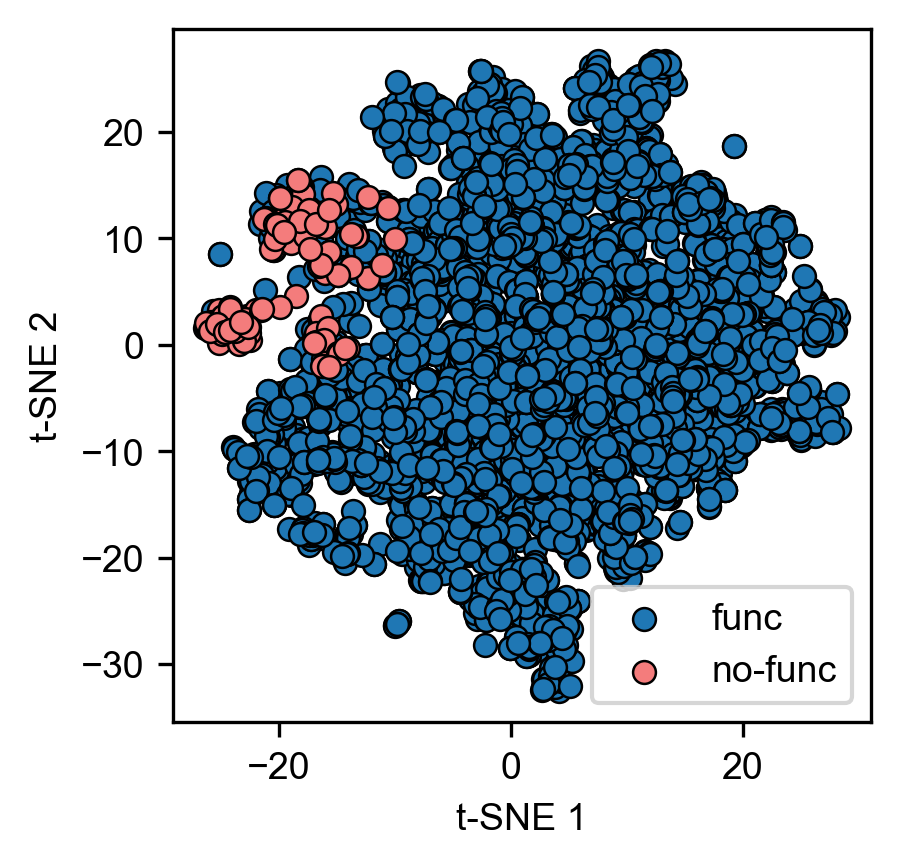

In [10]:
size=30

plt.figure(figsize=(3,3),dpi=300)
plt.scatter(X_tsne_nat[nonfunc_nat_df.index, 0], X_tsne_nat[nonfunc_nat_df.index, 1],
            edgecolor = 'k',s=size, lw=.6, label = 'func')
plt.scatter(X_tsne_nat[func_nat_df.index, 0], X_tsne_nat[func_nat_df.index, 1],
            edgecolor = 'k',s=size, lw=.6, c = '#f47c7c', label = 'no-func')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

## 4. Function & Phylogeny & Designed

Designed sequences fill gaps between evolutionary trajectories (phylogenies)

Data to show this conclusion is now drawn from "user defined" InfoVAE parameterizations

In [11]:
func_nat_plot = func_nat_df.copy()
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']

func_nat_plot['PhyGroup'] = np.nan
for j in range(len(phylogeny)):
    filter_1 = func_nat_plot['Phylogeny'].str.contains(phylogeny[j])
    func_nat_plot.loc[filter_1,'PhyGroup'] = phylogeny[j]

nodik = 'non-Dikarya fungi'
phylogeny.append(nodik)
filter_2 = ~func_nat_plot['Phylogeny'].str.contains('Dikarya')
filter_3 = func_nat_plot['Phylogeny'].str.contains('Fungi')
func_nat_plot.loc[filter_2 & filter_3,'PhyGroup'] = nodik

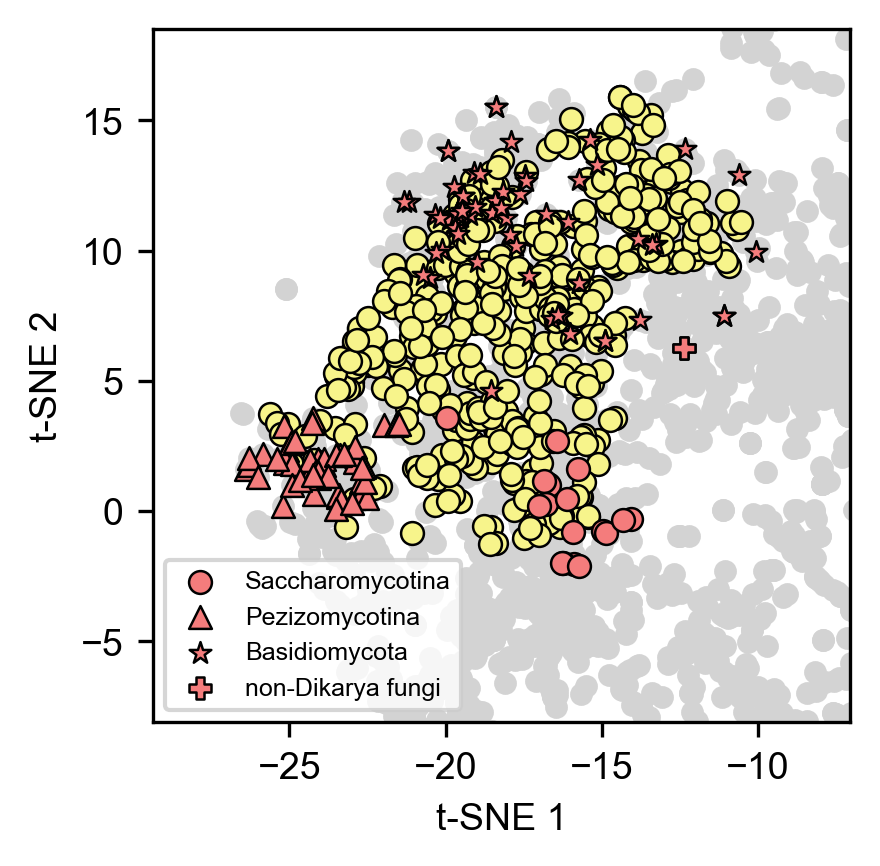

In [12]:
margin=3

xl = min(X_tsne_nat[func_nat_df.index, 0])-margin
xr = max(X_tsne_nat[func_nat_df.index, 0])+margin
yl = min(X_tsne_nat[func_nat_df.index, 1])-margin
yh = max(X_tsne_nat[func_nat_df.index, 1])+margin

plt.figure(figsize=(3,3),dpi=300)
plt.scatter(X_tsne_nat[:,0], X_tsne_nat[:,1], c = 'lightgray', s = 20)
plt.scatter(X_tsne_des[:,0], X_tsne_des[:,1], c = 'lightgray', s = 20)

plt.scatter(X_tsne_des[func_MMD_df.index,0], X_tsne_des[func_MMD_df.index,1], c = '#F7F48B',
            edgecolor = 'k', s = 30, lw=.6)

for g in range(4):
    ix = func_nat_plot[(func_nat_plot['PhyGroup'] == phylogeny[g]) & 
              (func_nat_plot['orthologous_group'] == 'NOG09120')].index
    plt.scatter(X_tsne_nat[ix,0], X_tsne_nat[ix,1], 
                marker = ['o','^','*','P'][g], c = '#f47c7c',
                label = phylogeny[g], edgecolor = 'k',s = 30, lw=.6)
plt.xlim([xl,xr])
plt.ylim([yl-3,yh])

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(loc = 'lower left',fontsize=6)
plt.show()

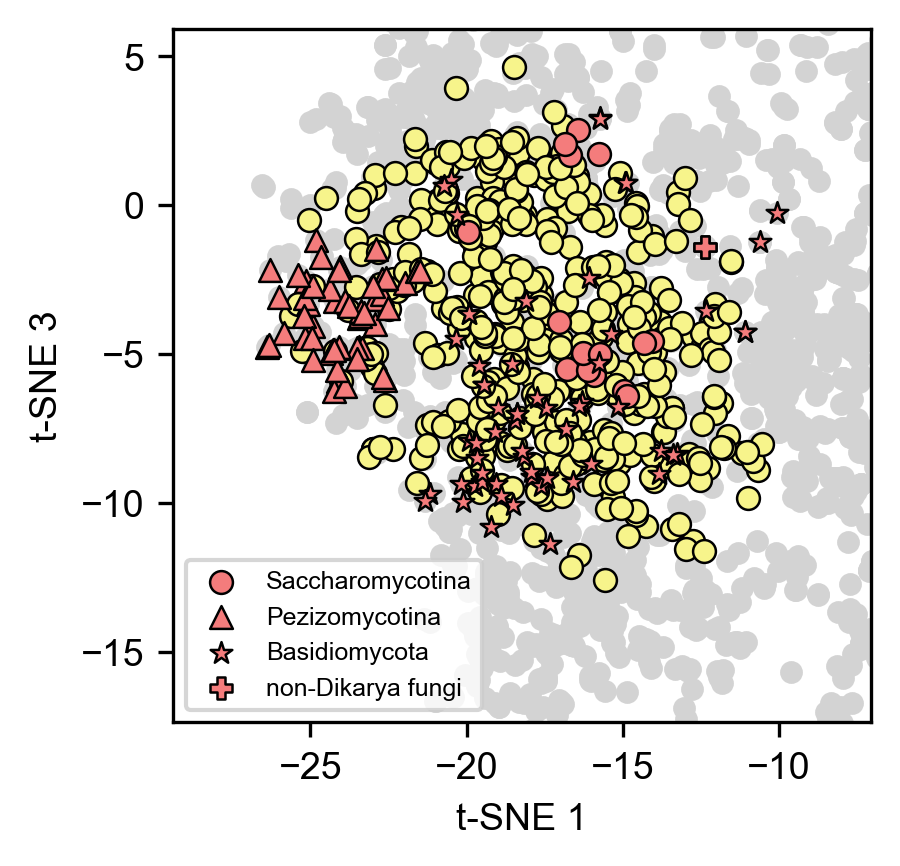

In [13]:
xl = min(X_tsne_nat[func_nat_df.index, 0])-margin
xr = max(X_tsne_nat[func_nat_df.index, 0])+margin
yl = min(X_tsne_nat[func_nat_df.index, 2])-margin
yh = max(X_tsne_nat[func_nat_df.index, 2])+margin

plt.figure(figsize=(3,3),dpi=300)
plt.scatter(X_tsne_nat[:,0], X_tsne_nat[:,2], c = 'lightgray', s = 20)
plt.scatter(X_tsne_des[:,0], X_tsne_des[:,2], c = 'lightgray', s = 20)

plt.scatter(X_tsne_des[func_MMD_df.index,0], X_tsne_des[func_MMD_df.index,2], c = '#F7F48B',
            edgecolor = 'k', s = 30, lw=.6)

for g in range(4):
    ix = func_nat_plot[(func_nat_plot['PhyGroup'] == phylogeny[g]) & 
              (func_nat_plot['orthologous_group'] == 'NOG09120')].index
    plt.scatter(X_tsne_nat[ix,0], X_tsne_nat[ix,2], 
                marker = ['o','^','*','P'][g], c = '#f47c7c',
                label = phylogeny[g], edgecolor = 'k',s = 30, lw=.6)
plt.xlim([xl,xr])
plt.ylim([yl-3,yh])

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 3')
plt.legend(loc = 'lower left',fontsize=6)
plt.show()

**Red**: natural functional

**Yellow**: InfoVAE designed functional

**Gray**: non-functional

## Convex hull

In [14]:
def compute_hull(data, hull):
    ix = np.where(data == hull)[0]
    coord = mmd_nat_coord[ix,:]
    return ConvexHull(coord)

def check_latent_in_hull(z_coord, hull, tolerance = 10**-12):
    decision = all((np.dot(equa[:-1], z_coord) + equa[-1] <= tolerance) for equa in hull.equations)
    return decision

def check_hull_list(l, hull):
    return np.array([check_latent_in_hull(i, hull) for i in l])

In [15]:
# create convex hull based on functional natural sho1s (# 132)
ix = func_nat_plot[func_nat_plot['orthologous_group'] == 'NOG09120'].index

ortho_hull = ConvexHull(X_tsne_nat[ix,:])

In [16]:
# check how many natural SH3 domains are in the convex hull
class_nat = check_hull_list(X_tsne_nat, ortho_hull)

print(f'Number of natural SH3 domains in the functional Sho1 convex hull: {sum(class_nat)}')

# check how many functinonal natural Sh3s are in the convex hull
func_class_nat = check_hull_list(X_tsne_nat[func_nat_df.index, :], ortho_hull)

print(f'Number of functional SH3 domains in the convex hull: {sum(func_class_nat)}')

# check how many nonfunctinonal natural Sh3s (training dataset only) are in the convex hull

nonfunc_class_nat = check_hull_list(X_tsne_nat[nonfunc_nat_df.index, :], ortho_hull)
print(f'Number of non-functional SH3 domains in the convex hull: {sum(nonfunc_class_nat)}')

Number of natural SH3 domains in the functional Sho1 convex hull: 159
Number of functional SH3 domains in the convex hull: 132
Number of non-functional SH3 domains in the convex hull: 27


In [17]:
# check how many designed SH3 domains are in the convex hull
class_des = check_hull_list(X_tsne_des, ortho_hull)

print(f'Number of designed SH3 domains in the functional Sho1 convex hull: {sum(class_des)}')

# check how many functinonal designed Sh3s are in the convex hull
func_class_des = check_hull_list(X_tsne_des[func_MMD_df.index, :], ortho_hull)

print(f'Number of functional SH3 domains in the convex hull: {sum(func_class_des)}')

# check how many nonfunctinonal designed Sh3s are in the convex hull

nonfunc_class_des = check_hull_list(X_tsne_des[nonfunc_MMD_df.index, :], ortho_hull)
print(f'Number of non-functional SH3 domains in the convex hull: {sum(nonfunc_class_des)}')

# check how many functinonal designed Sh3s are outside the convex hull
print(f'Number of functional SH3 domains outside the convex hull: {sum(~func_class_des)}')

Number of designed SH3 domains in the functional Sho1 convex hull: 339
Number of functional SH3 domains in the convex hull: 312
Number of non-functional SH3 domains in the convex hull: 27
Number of functional SH3 domains outside the convex hull: 156


In [18]:
len(func_MMD_df)

468